In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

### Obtenção dos Dados

In [82]:
DIR = './data'
CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('/')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('/'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file))
                list_of_img.append(df.values)

X = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

34970 files loaded.


### Exploração dos Dados

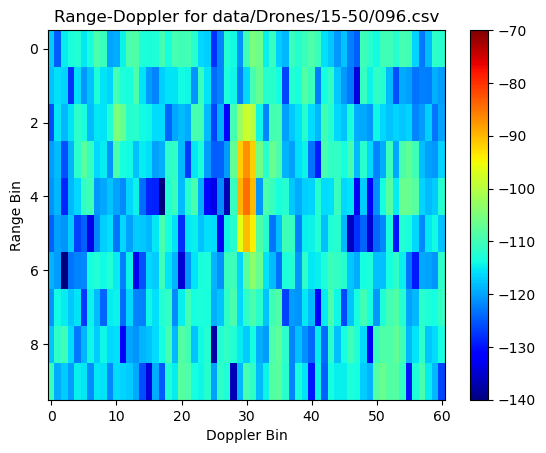

In [83]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[0], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[0]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

### Transformação dos Dados

In [84]:
X = X.reshape(-1, 10, 61, 1)

In [85]:
y = to_categorical(y)

In [86]:
X_train, _X, y_train, _y = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(_X, _y, test_size=0.5, random_state=42)

### A) Modelo Classificador (Rede Neural Convolucional)

In [87]:
from keras.layers import Input, BatchNormalization, Conv2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import MaxPooling2D
from keras.layers import LeakyReLU
from keras.models import Model

In [88]:
def make_cnn(img_cols, img_rows):

    input_image = Input(shape=(img_cols, img_rows, 1))

    # Layer 1
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    layer = BatchNormalization(name='norm_1')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)

    # Layer 2
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_2')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_2')(layer)

    # Layer 3
    layer = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_3')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_3')(layer)
    layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_3')(layer)

    layer = Flatten()(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dense(3, activation='softmax')(layer)

    model = Model(inputs=input_image, outputs=layer, name='CNN')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [89]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [90]:
model = make_cnn(10, 61)

In [91]:
_ = model.fit(
    X_train,
    y_train,
    epochs=1,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

383/383 [==============================] - 36s 93ms/step - loss: 0.3181 - accuracy: 0.8785 - val_loss: 0.3505 - val_accuracy: 0.8827 - lr: 0.0010


In [93]:
y_pred = model.predict(X_test, verbose=0)

In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [96]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.92      0.76      0.83      1720
      Drones       0.89      0.83      0.86      1543
      People       0.82      1.00      0.90      1983

    accuracy                           0.87      5246
   macro avg       0.88      0.86      0.86      5246
weighted avg       0.88      0.87      0.87      5246



[]

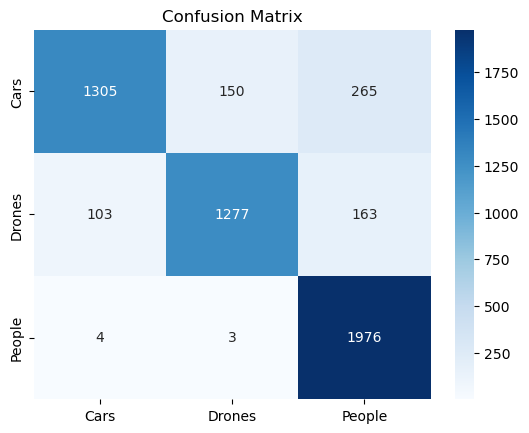

In [104]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

### B) Transfer Learning

### C) Fining Tunning

In [34]:
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
import numpy as np

In [35]:
input_tensor = Input(shape=(224, 224, 3))

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

80134624/80134624 [==============================] - 3s 0us/step


In [36]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
model.fit(...)